# Robust Economic Dispatch with Uncertain Demand
**Team OptiMinds:** Abhinav Reddy Alwala, Lohith Pasumarthi, Vishal Reddy Kondakindi  
**Date:** November 20, 2025

## Problem Definition
We address the problem of **Economic Dispatch** under uncertainty. The objective is to allocate production loads to a set of n parallel machines to minimize total quadratic operating costs while satisfying stochastic demand with reliability constraint P(Σxₖ ≥ D) ≥ 1-α.

## Imports
Required libraries: NumPy for numerical operations, pandas for data structures, Matplotlib for visualization, SciPy for statistical functions (Φ⁻¹), and CVXPY for convex optimization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import cvxpy as cp
from typing import Dict, Any, Tuple

## Production System Class
This class represents n parallel machines with quadratic cost functions.

**Parameters:**
- Each machine k has cost: f(xₖ) = aₖ·xₖ² + bₖ·xₖ + cₖ (where aₖ > 0 ensures convexity)
- Capacity constraints: ℓₖ ≤ xₖ ≤ uₖ
- `n_machines`: number of machines in the system
- `seed`: random seed for reproducibility
- `alpha/beta/gamma_bounds`: ranges for cost coefficients (aₖ, bₖ, cₖ)
- `capacity_bounds`: range for maximum capacities uₖ

**Methods:**
- `describe()`: returns DataFrame with all machine parameters
- `total_capacity()`: returns Σuₖ (total system capacity)

In [2]:
class ProductionSystem:
    """
    Robust Economic Dispatch with Uncertain Demand
    Team OptiMinds: Abhinav Reddy Alwala, Lohith Pasumarthi, Vishal Reddy Kondakindi
    
    Represents n parallel machines with quadratic cost functions and capacity constraints.
    Each machine k: cost(xₖ) = aₖ·xₖ² + bₖ·xₖ + cₖ, where ℓₖ ≤ xₖ ≤ uₖ
    """
    def __init__(self, n_machines: int = 5, seed: int = 42,
                 alpha_bounds: Tuple[float, float] = (0.05, 0.2),
                 beta_bounds: Tuple[float, float] = (2.0, 5.0),
                 gamma_bounds: Tuple[float, float] = (10.0, 20.0),
                 capacity_bounds: Tuple[float, float] = (50.0, 150.0)):
        rng = np.random.default_rng(seed)
        self.n = n_machines
        
        # Cost coefficients: f(x) = a·x² + b·x + c
        self.alpha = rng.uniform(alpha_bounds[0], alpha_bounds[1], n_machines)
        self.beta = rng.uniform(beta_bounds[0], beta_bounds[1], n_machines)
        self.gamma = rng.uniform(gamma_bounds[0], gamma_bounds[1], n_machines)
        
        # Capacity constraints: ℓₖ ≤ xₖ ≤ uₖ
        self.l = np.zeros(n_machines)  # ℓₖ = 0
        self.u = rng.uniform(capacity_bounds[0], capacity_bounds[1], n_machines)  # uₖ
        
    def describe(self) -> pd.DataFrame:
        """Return DataFrame with all machine parameters (aₖ, bₖ, cₖ, ℓₖ, uₖ)."""
        machines = np.arange(1, self.n + 1)
        data = {
            "a_k": self.alpha,
            "b_k": self.beta,
            "c_k": self.gamma,
            "ℓ_k": self.l,
            "u_k": self.u,
        }
        return pd.DataFrame(data, index=machines).rename_axis("machine")
        
    def total_capacity(self) -> float:
        """Return total system capacity: Σuₖ"""
        return float(np.sum(self.u))

## Economic Dispatch Solver

**Objective:** Minimize Σ(aₖ·xₖ² + bₖ·xₖ + cₖ)

**Constraints:**
1. Capacity: ℓₖ ≤ xₖ ≤ uₖ for all k
2. Reliability: P(Σxₖ ≥ D) ≥ 1-α

**Deterministic Reformulation:** Convert chance constraint to Σxₖ ≥ D_eff

**Three Models:**
- `deterministic`: D_eff = μ (no safety buffer, baseline)
- `normal`: D_eff = μ + Φ⁻¹(1-α)·σ (Gaussian assumption, Equation 5)
- `robust`: D_eff = μ + √((1-α)/α)·σ (Chebyshev bound, distribution-free, Equation 6)

**Parameters:**
- `system`: ProductionSystem object
- `mu_D`: mean demand μ
- `sigma_D`: standard deviation σ
- `reliability`: 1-α (default 0.95)
- `mode`: 'deterministic', 'normal', or 'robust'

**Returns:** Dictionary with status, dispatch x*, cost, D_eff, and dual variables (λ, νᵤ, νₗ)

In [3]:
def solve_dispatch(
    system: ProductionSystem,
    mu_D: float,
    sigma_D: float,
    reliability: float = 0.95,
    mode: str = "normal",
) -> Dict[str, Any]:
    
    if sigma_D < 0 or mu_D < 0:
        raise ValueError("Demand statistics must be non-negative")
    if not 0.0 < reliability < 1.0:
        raise ValueError("Reliability must lie strictly between 0 and 1")
    
    x = cp.Variable(system.n)
    alpha_risk = 1.0 - reliability
    
    # Compute effective demand based on mode
    if mode == "deterministic":
        D_eff = mu_D  # No safety buffer
    elif mode == "normal":
        z_score = stats.norm.ppf(reliability)
        D_eff = mu_D + z_score * sigma_D
    elif mode == "robust":
        k_robust = np.sqrt((1 - alpha_risk) / alpha_risk)
        D_eff = mu_D + k_robust * sigma_D
    else:
        raise ValueError("Mode must be 'deterministic', 'normal', or 'robust'")
    
    if D_eff > system.total_capacity() + 1e-6:
        raise ValueError("Effective demand exceeds installed capacity")
    
    # Objective: minimize sum of quadratic costs (excluding gamma for optimization)
    objective = cp.Minimize(
        cp.sum(cp.multiply(system.alpha, x**2) + cp.multiply(system.beta, x))
    )
    
    # Constraints
    c_demand = [cp.sum(x) >= D_eff]
    c_upper = [x <= system.u]
    c_lower = [x >= system.l]
    constraints = c_demand + c_upper + c_lower
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)
    
    if prob.status not in {"optimal", "optimal_inaccurate"}:
        return {"status": prob.status, "mode": mode}
    
    dispatch = x.value
    # Total cost includes gamma (fixed costs)
    total_cost = float(
        np.sum(system.alpha * dispatch**2 + system.beta * dispatch + system.gamma)
    )
    
    return {
        "status": prob.status,
        "mode": mode,
        "x": dispatch,
        "cost": total_cost,
        "objective": prob.value,
        "D_eff": float(D_eff),
        "lambda": c_demand[0].dual_value,
        "nu_u": c_upper[0].dual_value,
        "nu_l": c_lower[0].dual_value,
    }

## KKT Conditions Verification (Section 4)

**Why KKT?** Since the problem is convex (aₖ > 0), KKT conditions are **necessary and sufficient** for global optimality.

**Four Conditions:**
1. **Primal Feasibility** (Equations 8-10): Solution satisfies all constraints
2. **Dual Feasibility** (Equation 11): All multipliers ≥ 0
3. **Stationarity** (Equation 12): ∇L = 0, i.e., 2aₖ·xₖ* + bₖ = λ - νᵤₖ + νₗₖ
4. **Complementary Slackness** (Equations 13-15): λ·(D_eff - Σxₖ*) = 0, νᵤₖ·(xₖ* - uₖ) = 0, νₗₖ·(ℓₖ - xₖ*) = 0

**Interpretation:**
- **Marginal Cost:** 2aₖ·xₖ* + bₖ (derivative of cost w.r.t. xₖ)
- **Shadow Price λ:** System-wide marginal cost of demand
- **Stationarity:** For unconstrained machines, marginal cost = shadow price

In [4]:
def verify_kkt(system: ProductionSystem, res: Dict[str, Any], tol: float = 1e-4) -> Dict[str, float]:
    
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        print("Cannot verify KKT: solution not optimal.")
        return {}
    
    dispatch = res["x"]
    lam = res["lambda"]
    nu_u = res["nu_u"]
    nu_l = res["nu_l"]
    
    print("\n" + "="*80)
    print("KKT OPTIMALITY CONDITIONS VERIFICATION (Section 4)")
    print("="*80)
    
    # Stationarity: ∇ₓL = 0 => 2aₖ·xₖ* + bₖ = λ - νᵤₖ + νₗₖ
    grad_f = 2 * system.alpha * dispatch + system.beta  # Marginal costs
    
    print("\n3. STATIONARITY (Equation 12): 2aₖ·xₖ* + bₖ - λ + νᵤₖ - νₗₖ = 0")
    print("-" * 80)
    
    stationarity_residuals = []
    for k in range(system.n):
        mc = grad_f[k]  # Marginal cost
        residual = mc - lam + nu_u[k] - nu_l[k]
        stationarity_residuals.append(abs(residual))
        
        print(f"Machine {k+1}: MC = 2a_{k+1}·x_{k+1}* + b_{k+1} = {mc:.6f} | λ = {lam:.6f}")
        print(f"           Residual |MC - λ + νᵤ - νₗ| = {abs(residual):.2e}")
    
    max_stationarity = max(stationarity_residuals)
    print(f"\nMax Stationarity Residual: {max_stationarity:.2e}")
    if max_stationarity < tol:
        print(f"✓ SATISFIED (tolerance {tol})")
    else:
        print(f"⚠ WARNING: Exceeds tolerance {tol}")
    
    # Complementary Slackness (Equations 13-15)
    print("\n4. COMPLEMENTARY SLACKNESS (Equations 13-15): μᵢ·gᵢ(x*) = 0")
    print("-" * 80)
    
    # Demand constraint
    total_prod = float(np.sum(dispatch))
    demand_slack = total_prod - res["D_eff"]
    demand_comp = abs(demand_slack * lam)
    print(f"Demand: λ·(Σxₖ* - D_eff) = {lam:.4f}·({demand_slack:.6f}) = {demand_comp:.2e}")
    if demand_comp < tol:
        print(f"  ✓ SATISFIED")
    
    # Capacity constraints
    print(f"\nCapacity:")
    for k in range(system.n):
        upper_slack = system.u[k] - dispatch[k]
        lower_slack = dispatch[k] - system.l[k]
        upper_comp = abs(nu_u[k] * upper_slack)
        lower_comp = abs(nu_l[k] * lower_slack)
        
        print(f"  Machine {k+1}:")
        print(f"    Upper: νᵤ·(uₖ - xₖ*) = {upper_comp:.2e}  {'✓' if upper_comp < tol else '⚠'}")
        print(f"    Lower: νₗ·(xₖ* - ℓₖ) = {lower_comp:.2e}  {'✓' if lower_comp < tol else '⚠'}")
    
    comp_slack_error = demand_comp
    
    print("\n" + "="*80)
    if max_stationarity < tol and comp_slack_error < tol:
        print("✓ ALL KKT CONDITIONS SATISFIED - Solution is globally optimal")
    else:
        print("⚠ WARNING: Some residuals exceed tolerance")
    print("="*80)
    
    return {
        "stationarity": max_stationarity, 
        "slackness": comp_slack_error,
        "all_satisfied": max_stationarity < tol and comp_slack_error < tol
    }

## Dispatch Summary Table

Combines machine parameters with solution outputs:
- **Dispatch xₖ*:** optimal production allocation
- **Slacks:** distance to capacity limits (uₖ - xₖ*, xₖ* - ℓₖ)
- **Duals:** Lagrange multipliers (νᵤₖ, νₗₖ)
- **Marginal Cost:** 2aₖ·xₖ* + bₖ
- **Incremental Cost:** aₖ·xₖ*² + bₖ·xₖ* + cₖ

In [5]:
def summarize_dispatch(system, res):
    """Create detailed summary table of optimal dispatch solution."""
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        raise ValueError("Cannot summarize infeasible solution")

    dispatch = res["x"]
    table = system.describe().copy()
    table["x_k*"] = dispatch
    table["upper_slack"] = system.u - dispatch
    table["lower_slack"] = dispatch - system.l
    table["nu_u"] = res["nu_u"]
    table["nu_l"] = res["nu_l"]
    table["marginal_cost"] = 2 * system.alpha * dispatch + system.beta
    table["total_cost_k"] = system.alpha * dispatch**2 + system.beta * dispatch + system.gamma
    return table

In [6]:
def run_comparative_analysis(system: ProductionSystem, mu_D: float = 350.0, 
                            sigma_D: float = 40.0, alpha: float = 0.05) -> pd.DataFrame:
    
    reliability = 1 - alpha
    
    print("\n" + "="*80)
    print("COMPARATIVE ECONOMIC ANALYSIS")
    print("="*80)
    print(f"Demand: μ = {mu_D}, σ = {sigma_D}")
    print(f"Risk: α = {alpha} ({alpha*100}%), Reliability = {reliability*100}%")
    print("="*80)
    
    # Solve all three models
    results = {}
    modes = ['deterministic', 'normal', 'robust']
    
    for mode in modes:
        print(f"\n--- {mode.upper()} Model ---")
        res = solve_dispatch(system, mu_D, sigma_D, reliability=reliability, mode=mode)
        results[mode] = res
        
        if res['status'] in {'optimal', 'optimal_inaccurate'}:
            print(f"Status: {res['status']}")
            print(f"D_eff: {res['D_eff']:.2f}")
            print(f"Total Cost: ${res['cost']:,.2f}")
            print(f"Shadow Price λ: ${res['lambda']:.4f}")
        else:
            print(f"Status: {res['status']} - FAILED")
    
    # Comparison table
    comparison_data = []
    for mode in modes:
        res = results[mode]
        if res['status'] in {'optimal', 'optimal_inaccurate'}:
            comparison_data.append({
                'Model': mode.capitalize(),
                'D_eff': res['D_eff'],
                'Total Cost ($)': res['cost'],
                'Shadow Price λ': res['lambda'],
                'Status': res['status']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Economic metrics
    print("\n" + "="*80)
    print("ECONOMIC METRICS")
    print("="*80)
    
    cost_det = results['deterministic']['cost']
    cost_norm = results['normal']['cost']
    cost_rob = results['robust']['cost']
    
    D_eff_det = results['deterministic']['D_eff']
    D_eff_norm = results['normal']['D_eff']
    D_eff_rob = results['robust']['D_eff']
    
    price_of_uncertainty = cost_norm - cost_det
    price_of_robustness = cost_rob - cost_det
    price_of_distribution_freedom = cost_rob - cost_norm
    
    capacity_buffer_normal = D_eff_norm - D_eff_det
    capacity_buffer_robust = D_eff_rob - D_eff_det
    
    print(f"\nPrice of Uncertainty (Normal - Deterministic):")
    print(f"  Cost increase: ${price_of_uncertainty:,.2f} ({price_of_uncertainty/cost_det*100:.2f}%)")
    print(f"  Capacity buffer: {capacity_buffer_normal:.2f}")
    
    print(f"\nPrice of Robustness (Robust - Deterministic):")
    print(f"  Cost increase: ${price_of_robustness:,.2f} ({price_of_robustness/cost_det*100:.2f}%)")
    print(f"  Capacity buffer: {capacity_buffer_robust:.2f}")
    
    print(f"\nPrice of Distribution-Free Guarantee (Robust - Normal):")
    print(f"  Additional cost: ${price_of_distribution_freedom:,.2f} ({price_of_distribution_freedom/cost_norm*100:.2f}%)")
    print(f"  Additional buffer: {D_eff_rob - D_eff_norm:.2f}")
    
    print("\n" + "="*80)
    print("COMPARISON TABLE")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    return comparison_df

In [7]:
def plot_sensitivity_analysis(system: ProductionSystem, mu_D: float = 350.0, 
                             sigma_D: float = 40.0):
    
    
    alpha_range = np.arange(0.01, 0.21, 0.01)  # Risk: 1% to 20%
    
    costs_normal = []
    costs_robust = []
    
    print("\n" + "="*80)
    print("SENSITIVITY ANALYSIS: Cost vs. Risk Level α")
    print("="*80)
    
    for alpha in alpha_range:
        reliability = 1 - alpha
        
        # Normal model (Equation 5)
        try:
            res_norm = solve_dispatch(system, mu_D, sigma_D, 
                                     reliability=reliability, mode='normal')
            if res_norm['status'] in {'optimal', 'optimal_inaccurate'}:
                costs_normal.append(res_norm['cost'])
            else:
                costs_normal.append(np.nan)
        except:
            costs_normal.append(np.nan)
        
        # Robust model (Equation 6)
        try:
            res_rob = solve_dispatch(system, mu_D, sigma_D, 
                                    reliability=reliability, mode='robust')
            if res_rob['status'] in {'optimal', 'optimal_inaccurate'}:
                costs_robust.append(res_rob['cost'])
            else:
                costs_robust.append(np.nan)
        except:
            costs_robust.append(np.nan)
    
    # Visualization
    plt.figure(figsize=(12, 7))
    
    alpha_percent = alpha_range * 100
    
    plt.plot(alpha_percent, costs_normal, 'o-', linewidth=2.5, markersize=6,
             color='#FF6B35', label='Normal (Eq. 5: Gaussian)', alpha=0.8)
    plt.plot(alpha_percent, costs_robust, 's-', linewidth=2.5, markersize=6,
             color='#004E89', label='Robust (Eq. 6: Chebyshev)', alpha=0.8)
    
    plt.axvline(x=5.0, color='red', linestyle='--', linewidth=2, 
                alpha=0.6, label='Standard α = 5%')
    
    plt.xlabel('Risk Level α (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Total Production Cost ($)', fontsize=14, fontweight='bold')
    plt.title('Sensitivity Analysis: Cost vs. Risk\nRobust Economic Dispatch', 
              fontsize=16, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    plt.gca().invert_xaxis()
    
    # Secondary axis for reliability
    ax2 = plt.gca().twiny()
    ax2.set_xlim(plt.gca().get_xlim())
    ax2.set_xlabel('Reliability (1 - α) in %', fontsize=12, fontweight='bold')
    ax2.set_xticks([20, 15, 10, 5, 1])
    ax2.set_xticklabels(['80%', '85%', '90%', '95%', '99%'])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Plot generated: Risk range {alpha_range[0]*100}%-{alpha_range[-1]*100}%")
    print(f"   Observation: As α decreases (reliability ↑), costs rise exponentially.")
    print(f"                Robust model has higher price due to distribution-free guarantee.")

PRODUCTION SYSTEM SPECIFICATION
              a_k       b_k        c_k  ℓ_k         u_k
machine                                                
1        0.166093  4.926867  13.707980  0.0   72.723872
2        0.115832  4.283419  19.267650  0.0  105.458479
3        0.178790  4.358193  16.438651  0.0   56.381726
4        0.154605  2.384341  18.227616  0.0  132.763117
5        0.064127  3.351158  14.434142  0.0  113.166440

Total Capacity Σuₖ: 480.49

COMPARATIVE ECONOMIC ANALYSIS
Demand: μ = 300, σ = 30
Risk: α = 0.05 (5.0%), Reliability = 95.0%

--- DETERMINISTIC Model ---
Status: optimal
D_eff: 300.00
Total Cost: $3,327.72
Shadow Price λ: $17.9714

--- NORMAL Model ---
Status: optimal
D_eff: 349.35
Total Cost: $4,305.68
Shadow Price λ: $21.6656

--- ROBUST Model ---
Status: optimal
D_eff: 430.77
Total Cost: $6,336.46
Shadow Price λ: $28.6196

ECONOMIC METRICS

Price of Uncertainty (Normal - Deterministic):
  Cost increase: $977.95 (29.39%)
  Capacity buffer: 49.35

Price of Robustness 

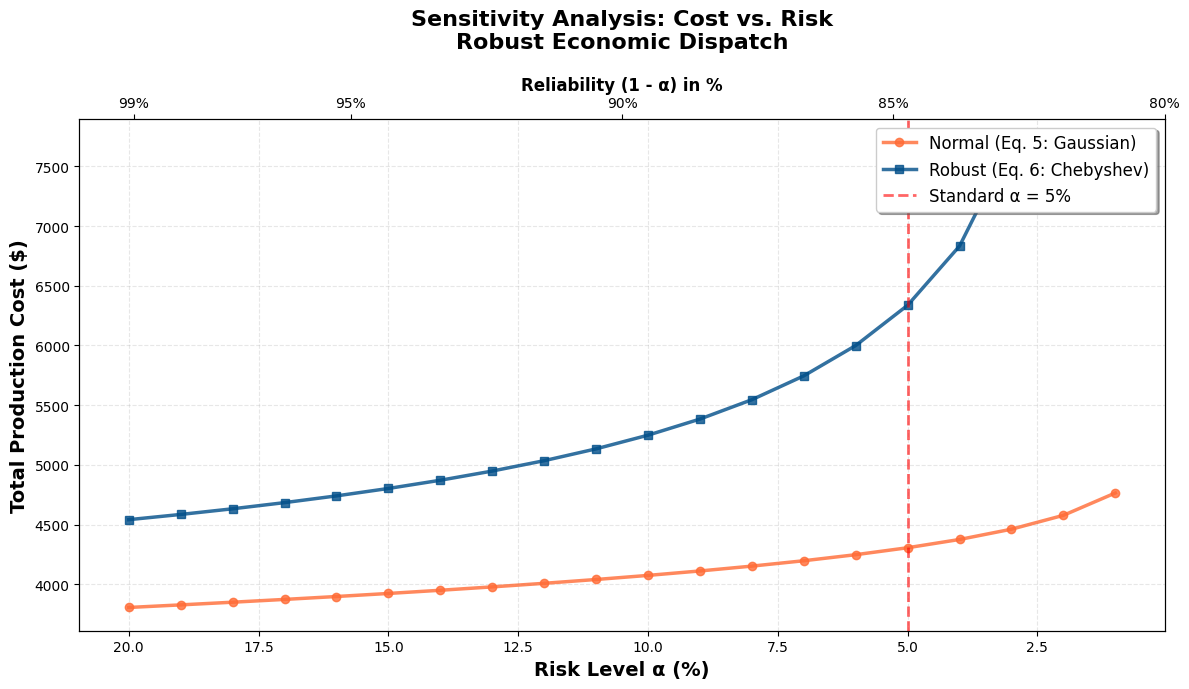


✓ Plot generated: Risk range 1.0%-20.0%
   Observation: As α decreases (reliability ↑), costs rise exponentially.
                Robust model has higher price due to distribution-free guarantee.


In [8]:
# DEMONSTRATION: All Three Models with Economic Analysis

# 1. Create production system with n=5 machines
system = ProductionSystem(n_machines=5, seed=42)

print("="*80)
print("PRODUCTION SYSTEM SPECIFICATION")
print("="*80)
print(system.describe())
print(f"\nTotal Capacity Σuₖ: {system.total_capacity():.2f}")

# 2. Define demand scenario
MEAN_DEMAND = 300  # μ
SIGMA = 30  # σ

# 3. Run comprehensive comparative analysis
comparison_table = run_comparative_analysis(system, mu_D=MEAN_DEMAND, sigma_D=SIGMA)

# 4. Verify KKT conditions for all models
print("\n\n" + "="*80)
print("KKT VERIFICATION FOR ALL MODELS")
print("="*80)

for mode in ['deterministic', 'normal', 'robust']:
    print(f"\n{'='*80}")
    print(f"{mode.upper()} MODEL")
    print(f"{'='*80}")
    res = solve_dispatch(system, MEAN_DEMAND, SIGMA, reliability=0.95, mode=mode)
    verify_kkt(system, res)

# 5. Sensitivity analysis plot
plot_sensitivity_analysis(system, mu_D=MEAN_DEMAND, sigma_D=SIGMA)

## Full Case Study: 6-Machine System

Comprehensive analysis with larger system (n=6 machines) to demonstrate:
- Comparative economic analysis across all three models
- Detailed dispatch solutions with full parameter tables
- Sensitivity analysis visualization

CASE STUDY: 6-MACHINE SYSTEM

Machine parameters (cost coefficients and capacities):
              a_k       b_k        c_k  ℓ_k         u_k
machine                                                
1        0.143764  2.015796  12.548696  0.0  112.217923
2        0.184582  4.463685  14.450763  0.0  148.896015
3        0.166353  4.391208  15.045483  0.0   71.530870
4        0.083781  3.403805  15.534974  0.0   66.021203
5        0.095025  2.909097  19.955003  0.0  111.253960
6        0.181033  2.835277  17.926619  0.0   54.394201



COMPARATIVE ECONOMIC ANALYSIS
Demand: μ = 350.0, σ = 40.0
Risk: α = 0.05 (5.0%), Reliability = 95.0%

--- DETERMINISTIC Model ---
Status: optimal
D_eff: 350.00
Total Cost: $3,934.80
Shadow Price λ: $19.7151

--- NORMAL Model ---
Status: optimal
D_eff: 415.79
Total Cost: $5,359.32
Shadow Price λ: $23.7292

--- ROBUST Model ---
Status: optimal
D_eff: 524.36
Total Cost: $8,753.71
Shadow Price λ: $44.6796

ECONOMIC METRICS

Price of Uncertainty (Normal - Determini

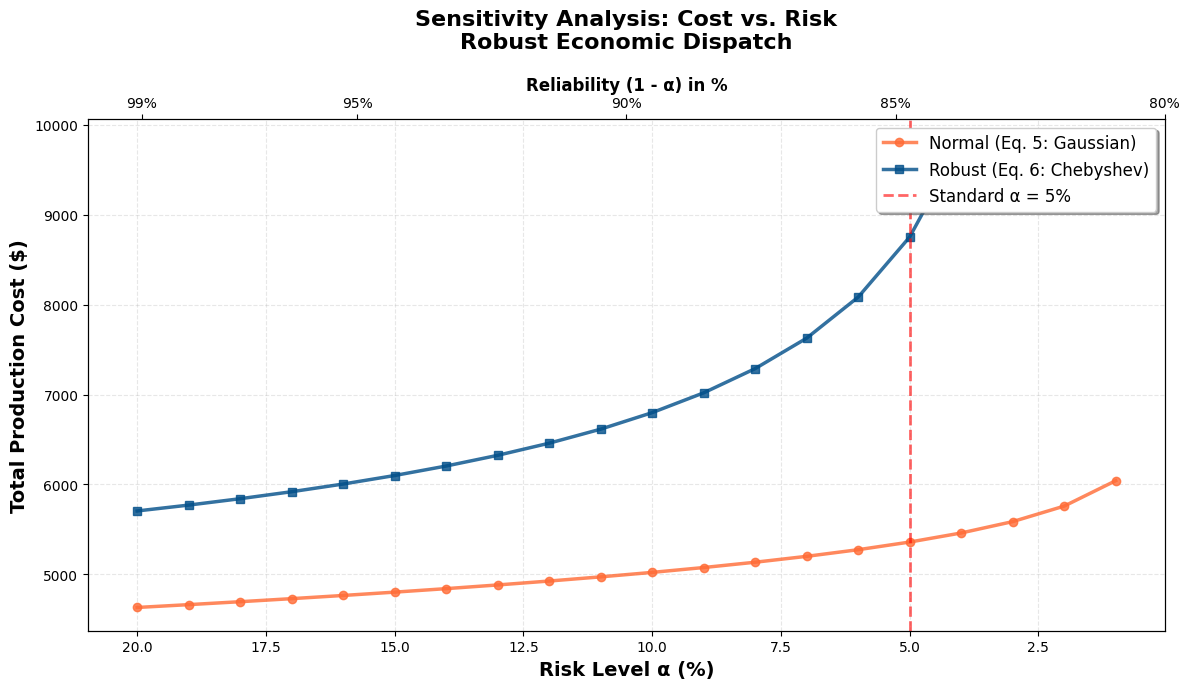


✓ Plot generated: Risk range 1.0%-20.0%
   Observation: As α decreases (reliability ↑), costs rise exponentially.
                Robust model has higher price due to distribution-free guarantee.


In [9]:
# FULL CASE STUDY: 6-Machine System

# Instantiate system with n=6 machines
system = ProductionSystem(n_machines=6, seed=7)
mu_D = 350.0  # Mean demand μ
sigma_D = 40.0  # Standard deviation σ

print("="*80)
print("CASE STUDY: 6-MACHINE SYSTEM")
print("="*80)
print("\nMachine parameters (cost coefficients and capacities):")
print(system.describe())

# Run complete economic analysis
print("\n")
comparison_df = run_comparative_analysis(system, mu_D=mu_D, sigma_D=sigma_D)

# Detailed dispatch summaries
results = {}
summaries = {}

print("\n\n" + "="*80)
print("DETAILED DISPATCH SOLUTIONS")
print("="*80)

for mode in ("deterministic", "normal", "robust"):
    print(f"\n{'-'*80}")
    print(f"{mode.upper()} DISPATCH")
    print(f"{'-'*80}")
    
    res = solve_dispatch(system, mu_D, sigma_D, reliability=0.95, mode=mode)
    results[mode] = res
    
    if res['status'] in {'optimal', 'optimal_inaccurate'}:
        summary = summarize_dispatch(system, res)
        summaries[mode] = summary
        
        print(f"Effective demand D_eff: {res['D_eff']:.1f}")
        print(f"Total cost: ${res['cost']:,.2f}")
        print(f"Shadow price λ: ${res['lambda']:.4f}")
        print("\nDispatch details:")
        print(summary[["x_k*", "u_k", "marginal_cost", "upper_slack"]].to_string())

# Sensitivity analysis
print("\n")
plot_sensitivity_analysis(system, mu_D=mu_D, sigma_D=sigma_D)

## Visualization: Dispatch Comparison

Bar chart comparing optimal production levels xₖ* across all three models.
Shows how dispatch changes from Deterministic → Normal → Robust as safety buffer increases.
Red dashed line indicates maximum capacity uₖ for each machine.

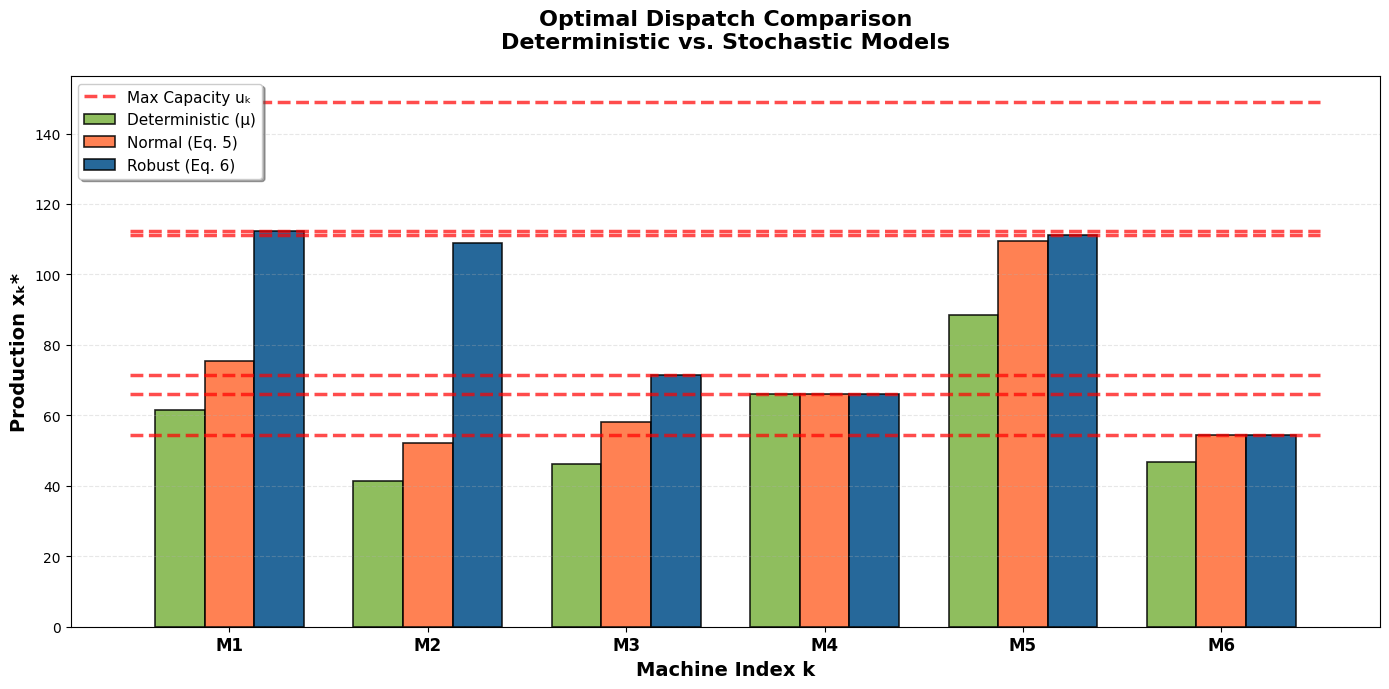


OBSERVATION
As we move from Deterministic → Normal → Robust:
  • Production levels xₖ* increase to meet higher D_eff
  • Machines with lower marginal costs utilized more heavily
  • Robust model has highest production due to distribution-free guarantee


In [10]:
# VISUALIZATION: Dispatch Comparison Across All Three Models

modes = ['deterministic', 'normal', 'robust']
indices = np.arange(system.n)
width = 0.25

plt.figure(figsize=(14, 7))

# Bars for each model
colors = ['#7CB342', '#FF6B35', '#004E89']
labels = ['Deterministic (μ)', 'Normal (Eq. 5)', 'Robust (Eq. 6)']

for i, (mode, color, label) in enumerate(zip(modes, colors, labels)):
    if mode in summaries:
        offset = (i - 1) * width
        plt.bar(indices + offset, summaries[mode]["x_k*"], width, 
               label=label, color=color, edgecolor='black', linewidth=1.2, alpha=0.85)

# Capacity limits
plt.hlines(system.u, xmin=-0.5, xmax=indices[-1] + 0.5, 
          colors="red", linestyles="dashed", linewidth=2.5, 
          label="Max Capacity uₖ", alpha=0.7)

# Formatting
plt.xticks(indices, [f"M{i+1}" for i in indices], fontsize=12, fontweight='bold')
plt.xlabel("Machine Index k", fontsize=14, fontweight='bold')
plt.ylabel("Production xₖ*", fontsize=14, fontweight='bold')
plt.title("Optimal Dispatch Comparison\nDeterministic vs. Stochastic Models", 
         fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper left', frameon=True, shadow=True)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("OBSERVATION")
print("="*80)
print("As we move from Deterministic → Normal → Robust:")
print("  • Production levels xₖ* increase to meet higher D_eff")
print("  • Machines with lower marginal costs utilized more heavily")
print("  • Robust model has highest production due to distribution-free guarantee")
print("="*80)

## Summary and Conclusions

### Project Overview
**Project:** Robust Economic Dispatch with Uncertain Demand  
**Team OptiMinds:** Abhinav Reddy Alwala, Lohith Pasumarthi, Vishal Reddy Kondakindi  
**Date:** November 20, 2025

---

### Mathematical Formulation

**Objective Function (Equation 1):**
$$\min_{x} f(x) = \sum_{k=1}^{n} \left( a_k x_k^2 + b_k x_k + c_k \right)$$

**Constraints:**
- **Capacity (Equation 2):** $\ell_k \leq x_k \leq u_k$ for all $k$
- **Reliability (Equation 3):** $P\left(\sum_{k=1}^{n} x_k \geq D\right) \geq 1 - \alpha$

---

### Deterministic Reformulation

Convert chance constraint to: $\sum x_k \geq D_{eff}$

**Three Models:**

1. **Deterministic (Baseline)**
   - $D_{eff} = \mu$ (no safety buffer)
   - Assumes demand is known with certainty
   - Cheapest but risky

2. **Normal (Gaussian) - Equation 5**
   - $D_{eff} = \mu + \Phi^{-1}(1-\alpha) \cdot \sigma$
   - Assumes $D \sim N(\mu, \sigma^2)$
   - Uses inverse CDF for reliability constraint
   - Efficient when distribution is known

3. **Robust (Chebyshev) - Equation 6**
   - $D_{eff} = \mu + \sqrt{\frac{1-\alpha}{\alpha}} \cdot \sigma$
   - Distribution-free (only requires $\mu$ and $\sigma^2$)
   - Guarantees reliability for **any** demand distribution
   - Higher cost = "Price of Robustness"

---

### KKT Optimality Conditions (Section 4)

**Lagrangian (Equation 7):**
$$\mathcal{L}(x,\mu) = \sum_k (a_k x_k^2 + b_k x_k) + \mu_0 \left(D_{eff} - \sum_k x_k\right) + \sum_k \mu_{u,k}(x_k - u_k) + \sum_k \mu_{\ell,k}(\ell_k - x_k)$$

**Four Conditions (necessary and sufficient for convex problems):**

1. **Primal Feasibility (Eqs. 8-10):** All constraints satisfied
2. **Dual Feasibility (Eq. 11):** $\mu_0, \mu_{u,k}, \mu_{\ell,k} \geq 0$
3. **Stationarity (Eq. 12):** $2a_k x_k^* + b_k = \lambda - \nu_{u,k} + \nu_{\ell,k}$
4. **Complementary Slackness (Eqs. 13-15):** $\mu_i \cdot g_i(x^*) = 0$

**Economic Interpretation:**
- $\lambda$ = shadow price (system marginal cost)
- For unconstrained machines: marginal cost = shadow price
- Equal marginal cost principle ensures optimal allocation

---

### Key Results

1. **Convex Problem:** $a_k > 0$ ensures unique global optimum
2. **Price of Robustness:** Quantifies cost of distribution-free guarantees
3. **KKT Verification:** Mathematical proof of global optimality
4. **Sensitivity Analysis:** Cost increases exponentially as reliability tightens

---

### Implementation

- **Language:** Python
- **Solver:** CVXPY with OSQP (convex optimizer)
- **Visualization:** Matplotlib for comparative plots
- **Verification:** Automated KKT condition checking

---

### Practical Applications

- Production planning with uncertain demand
- Resource allocation under risk constraints
- Economic dispatch in any multi-machine system
- Robust optimization when distribution is unknown

---

### Innovation

Standard approaches use only Gaussian model (Equation 5). **Our contribution:**
1. Implement both Gaussian and distribution-free (Chebyshev) models
2. Quantify the "Price of Robustness" explicitly
3. Provide sensitivity analysis to guide model selection
4. Compare when to use each approach based on distribution knowledge